In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from botorch.utils.transforms import normalize

from activephasemap.models.np import NeuralProcess
from activephasemap.models.mtgp import MultiTaskGPVersion2 as GP
from activephasemap.utils.simulators import UVVisExperiment
from activephasemap.utils.settings import from_comp_to_spectrum, get_twod_grid

import matplotlib.ticker as ticker
import json 

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [3]:
ITERATION = 8
DATA_DIR = "./"
design_space_bounds = [(0.0, 87.0), (0.0,11.0)]

expt = UVVisExperiment(design_space_bounds, ITERATION, DATA_DIR+"/data/")
expt.generate(use_spline=True)
gp_model_args = {"model":"gp", "num_epochs" : 1, "learning_rate" : 1e-3, "verbose": 1}
np_model_args = {"num_iterations": 1, "verbose":True, "print_freq":100, "lr":5e-4}
input_dim = expt.dim

with open('../best_config.json') as f:
    best_np_config = json.load(f)
N_LATENT = best_np_config["z_dim"]

# Load trained GP model for p(z|c)
train_x = torch.load(DATA_DIR+'/output/train_x_%d.pt'%ITERATION, map_location=device)
train_y = torch.load(DATA_DIR+'/output/train_y_%d.pt'%ITERATION, map_location=device)
bounds = expt.bounds.to(device)
normalized_x = normalize(train_x, bounds).to(train_x)
gp_model = GP(normalized_x, train_y)
gp_state_dict = torch.load(DATA_DIR+'/output/gp_model_%d.pt'%(ITERATION), map_location=device)
gp_model.load_state_dict(gp_state_dict)

# Load trained NP model for p(y|z)
np_model = NeuralProcess(best_np_config["r_dim"], N_LATENT, best_np_config["h_dim"]).to(device)
np_model.load_state_dict(torch.load(DATA_DIR+'/output/np_model_%d.pt'%(ITERATION), map_location=device))

Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (8, 2) (8, 101)
Loading data from iteration 2 with shapes: (8, 2) (8, 101)
Loading data from iteration 3 with shapes: (8, 2) (8, 101)
Loading data from iteration 4 with shapes: (8, 2) (8, 101)
Loading data from iteration 5 with shapes: (8, 2) (8, 101)
Loading data from iteration 6 with shapes: (8, 2) (8, 101)
Loading data from iteration 7 with shapes: (8, 2) (8, 101)


<All keys matched successfully>

### Plot few samples from Nueral Process Model

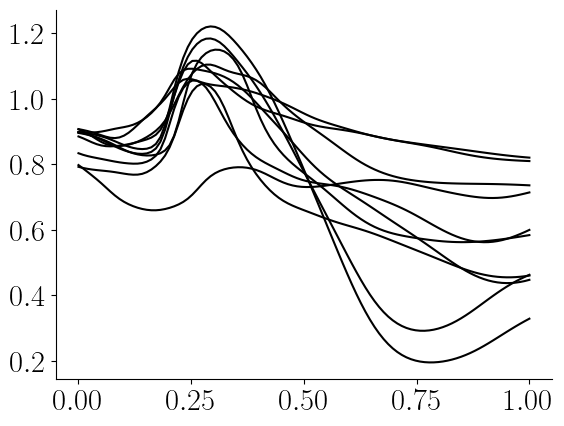

In [4]:
x_target = torch.Tensor(np.linspace(0, 1, 100)).to(device)
x_target = x_target.unsqueeze(1).unsqueeze(0)

with torch.no_grad(), plt.style.context(pyplot_style):
    fig, ax = plt.subplots()
    z_sample = torch.randn((10, N_LATENT)).to(device)
    for i in range(10):
        mu, _ = np_model.xz_to_y(x_target, z_sample[i,:])
        ax.plot(x_target.cpu().numpy()[0], mu.cpu().numpy()[0], color='k')
    plt.show()

### Plot random sample from GP model 

We randomly sample few points on the composition space and use it produce sampled curves from the composite model

/Users/pozzolabadmin/Documents/codebase/envs/activephasemap/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:607.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


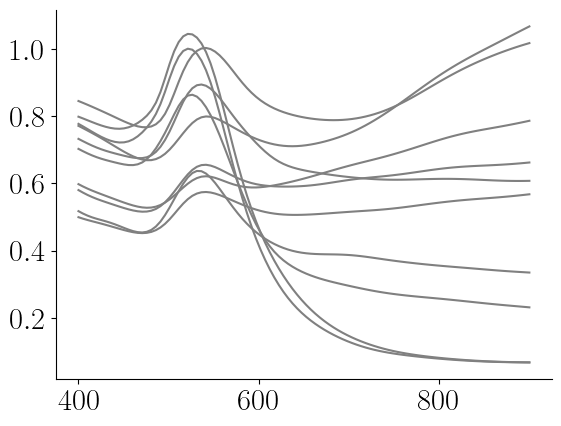

In [5]:
with torch.no_grad(), plt.style.context(pyplot_style):
    fig, ax = plt.subplots()

    rids = np.random.choice(expt.comps.shape[0], 10)
    for r in rids:
        c = expt.comps[r,:].reshape(1, expt.dim)
        mu, _ = from_comp_to_spectrum(expt, gp_model, np_model, c)
        mu_ = mu.cpu().squeeze()
        ax.plot(expt.wl, mu_, label="GP pred.", color="grey")
    plt.show()

### Plot phase map as predicted by the trained model
This requires us to pass composition to a GP model which predicts latent variables `z_pred`. The predicted `z_pred` are used to inturn sample a curve that is representative of the spectroscopic measurement at given composition.

In [9]:
grid_comps = get_twod_grid(10, bounds=expt.bounds.cpu().numpy())
grid_spectra = np.zeros((grid_comps.shape[0], expt.t.shape[0], 2 ))
with torch.no_grad():
    for i in range(grid_comps.shape[0]):
        mu, sigma = from_comp_to_spectrum(expt,
                                          gp_model, np_model,
                                          grid_comps[i,:].reshape(1,-1)
                                          )
        grid_spectra[i,:,0] = mu.cpu().squeeze().numpy()
        grid_spectra[i,:,1] = sigma.cpu().squeeze().numpy()

In [ ]:
def prettify_axis(ax):
    ax.set_xlabel('Z2 concentration (mM)')
    ax.set_ylabel('Time delay (min)') 
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    vol_labels = [item.get_text() for item in ax.get_xticklabels()]
    z2_vol_to_conc = lambda v : (0.3*v)/(280.0-v)
    conc_labels = []
    for l in vol_labels:
        conc_labels.append("%.2f"%z2_vol_to_conc(float(l)))
    ax.set_xticklabels(conc_labels)
    
    return ax

In [8]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    norm_grid_comps = normalize(grid_comps, expt.bounds.cpu().numpy())
    for i in range(grid_comps.shape[0]):
        loc_ax = ax.transLimits.transform(norm_grid_comps[i,:])
        ins_ax = ax.inset_axes([loc_ax[0],loc_ax[1],0.1,0.1])
        ins_ax.plot(expt.t, grid_spectra[i,:,0], color='k')
        ins_ax.fill_between(expt.t,
                            grid_spectra[i,:,0]-grid_spectra[i,:,1], 
                            grid_spectra[i,:,0]+grid_spectra[i,:,1],
                            color='grey')
        # ins_ax.set_ylim([0, grid_spectra[:,:,0].max()])
        ins_ax.axis('off')
            
    prettify_axis(ax)
    plt.savefig("./figures/grid_spectra_%d.png"%ITERATION)
    plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

### Plot collected data as points on a 2D plane

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_3078/1474876256.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(conc_labels)


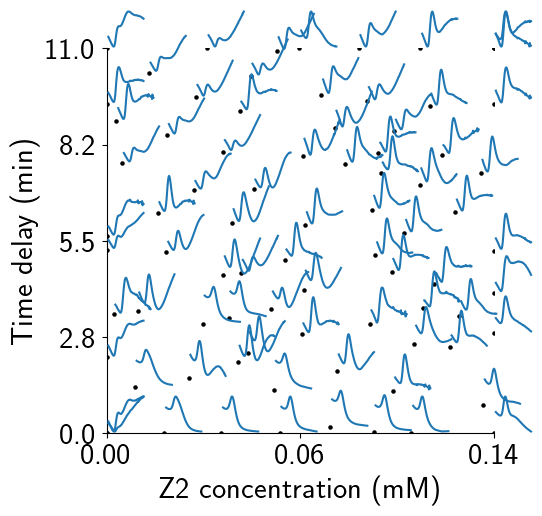

In [ ]:
with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    train_comps = expt.comps
    norm_train_comps = normalize(train_comps, expt.bounds.cpu().numpy())
    train_spectra = expt.spectra_normalized 
    for i in range(train_comps.shape[0]):
        loc_ax = ax.transLimits.transform(norm_train_comps[i,:])
        ins_ax = ax.inset_axes([loc_ax[0],loc_ax[1],0.1,0.1])
        ins_ax.plot(expt.t, train_spectra[i,:])
        # ins_ax.set_ylim([0, train_spectra.max()])
        ins_ax.axis('off')    
    ax.scatter(train_comps[:,0], train_comps[:,1], color='k', s=5)
    prettify_axis(ax)
    plt.savefig("./figures/train_spectra_%d.png"%ITERATION)
    plt.show()

### Plot acquisiton function at any given iteration

The acquisiton function is called on a dense grid of composition and represents the model predictive uncertainity at any given point in the composition.

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_3078/1474876256.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(conc_labels)


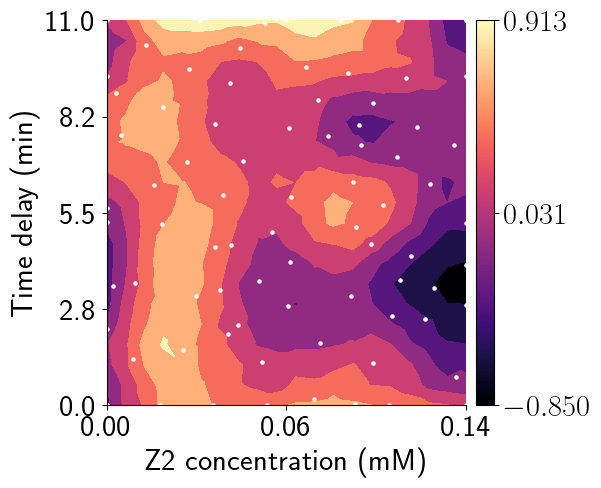

In [ ]:
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colormaps 
from matplotlib.cm import ScalarMappable
from activephasemap.utils.visuals import get_twod_grid
from activephasemap.utils.settings import construct_acqf_by_model

acquisition = construct_acqf_by_model(gp_model, normalized_x, train_y, N_LATENT)

C_grid = get_twod_grid(20, expt.bounds.cpu().numpy())
normalized_C_grid = normalize(torch.tensor(C_grid).to(train_x), expt.bounds.to(train_x))
with torch.no_grad():
    acq_values = acquisition(normalized_C_grid.reshape(len(C_grid),1,2)).cpu().numpy()
cmap = colormaps["magma"]
norm = Normalize(vmin=min(acq_values), vmax = max(acq_values))
mappable = ScalarMappable(norm=norm, cmap=cmap)

with torch.no_grad(), plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.tricontourf(C_grid[:,0], C_grid[:,1], acq_values, cmap=cmap, norm=norm)
    x_ = expt.comps
    ax.scatter(x_[:,0], x_[:,1], color='w', s=5)
    try:
        next_x = np.load(DATA_DIR+"./data/comps_%d.npy"%(ITERATION))
        ax.scatter(next_x[:,0], next_x[:,1], marker='x', color='tab:green', s=50, lw=2.0)
    except:
        pass
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.ax.yaxis.set_major_locator(ticker.LinearLocator(3))
    prettify_axis(ax)
    plt.savefig("./figures/acqf_%d.png"%ITERATION)   
    plt.show()

### Plot predictions of the model at trained compositions 
We randomly sample few training points and plot the model prediction to compare with the actual spectra

In [ ]:
def prettify_spectra_plot(ax, wl, spectra):
    ax.set_xlim([wl.min(), wl.max()])
    ax.set_ylim([spectra.min(), spectra.max()+0.2])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    return ax

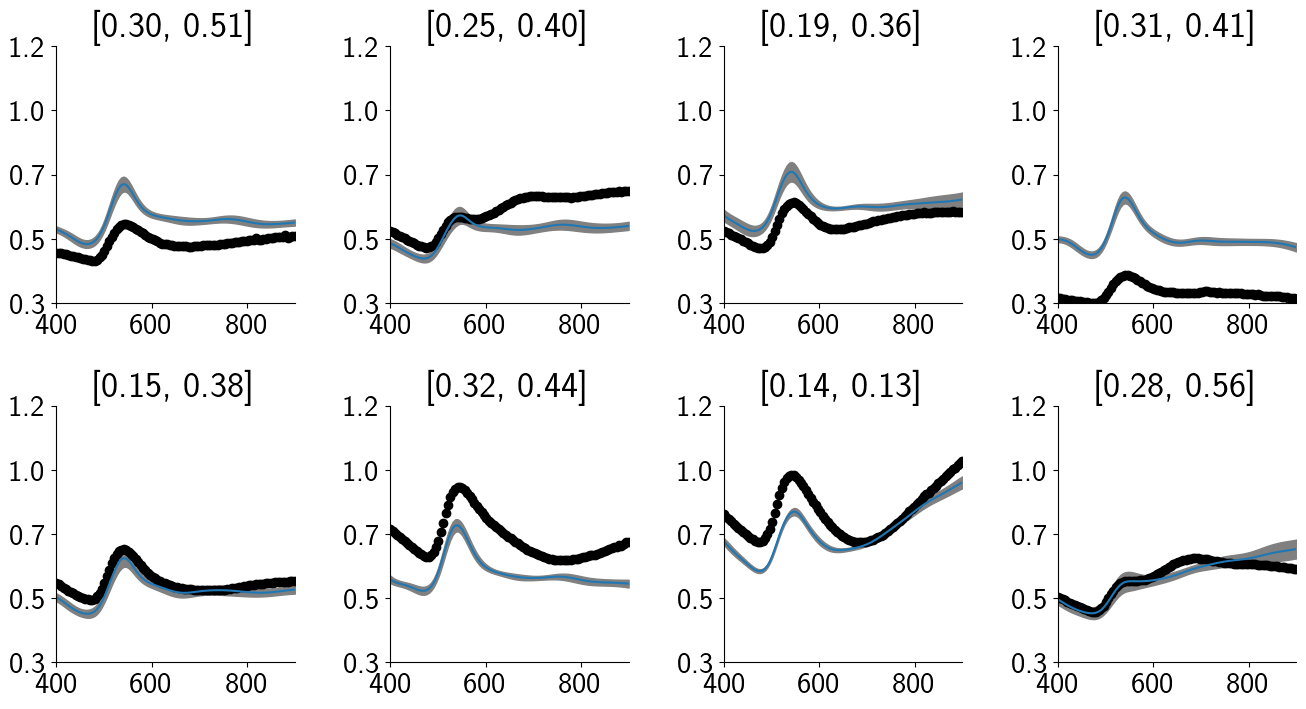

In [ ]:
from activephasemap.utils.visuals import plot_gpmodel_recon
from apdist.distances import AmplitudePhaseDistance as dist
from scipy.spatial import distance 

with plt.style.context(pyplot_style):
    fig, axs = plt.subplots(2,4, figsize=(4*4, 4*2))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    axs = axs.flatten() 
    rids = np.random.randint(0, expt.comps.shape[0], size=8)
    plot_comps = expt.comps[rids,:]
    plot_spectra = expt.spectra_normalized[rids,:]
    for i, ax in enumerate(axs):
        ci = plot_comps[i,:].reshape(1, -1)
        mu, sigma = from_comp_to_spectrum(expt, gp_model, np_model, ci)
        mu_ = mu.cpu().squeeze().numpy()
        sigma_ = sigma.cpu().squeeze().numpy()
        ax.plot(expt.wl, mu_)
        ax.fill_between(expt.wl,mu_-sigma_,mu_+sigma_,color='grey')
        ax.scatter(expt.wl, plot_spectra[i,:], color='k')
        optim_kwargs = {"optim":"DP", "grid_dim":10}
        amplitude, phase = dist(expt.t, plot_spectra[i,:], mu_, **optim_kwargs) 
        ax.set_title("[%.2f, %.2f]"%(amplitude, phase)) 
        # euclidean = distance.euclidean(plot_spectra[i,:], mu_) 
        # ax.set_title("%.2f"%euclidean)
        prettify_spectra_plot(ax, expt.wl, plot_spectra)
    plt.savefig("./figures/train_pred_%d.png"%ITERATION)
    plt.show()

### Plot predictions of the model at compositions it is currently requesting
We first predict the spectra at locations the model has requested to sample (because it has not seen spectra at those locations and thus are informative) and compare them with the actual sampled curve.

In [ ]:
next_comps = np.load(DATA_DIR+"/data/comps_%d.npy"%(ITERATION))
next_spectra = np.load(DATA_DIR+"/data/spectra_%d.npy"%(ITERATION))
wav = np.load(DATA_DIR+"/data/wav.npy")
time = (wav-min(wav))/(max(wav)-min(wav))
with plt.style.context(pyplot_style):
    fig, axs = plt.subplots(2,4, figsize=(4*4, 4*2))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        # plot_gpmodel_recon(ax, gp_model, np_model, expt, next_comps[i,:].reshape(1, -1))
        comp = next_comps[i,:].reshape(-1,1)
        c = torch.from_numpy(comp).to(device)

        tt = torch.from_numpy(time).to(device)
        x_target = tt.repeat(comp.shape[0]).view(comp.shape[0], len(time), 1)

        with torch.no_grad():
            gp_model.eval()
            normalized_x = normalize(c, bounds.to(c))
            posterior = gp_model.posterior(normalized_x)

            mu_list = []
            for _ in range(250):
                mu_i, _ = np_model.xz_to_y(x_target, posterior.rsample().squeeze(0))
                mu_list.append(mu_i)
        mu = torch.cat(mu_list).mean(dim=0, keepdim=True)
        sigma = torch.cat(mu_list).std(dim=0, keepdim=True)
        y_pred = mu.cpu().squeeze().numpy()
        sigma_ = sigma.cpu().squeeze().numpy()
        ax.plot(wav, y_pred)
        ax.fill_between(wav,y_pred-sigma_,y_pred+sigma_,color='grey')
        y_true = next_spectra[i,:]
        ax.scatter(wav, y_true, color='k')
        optim_kwargs = {"optim":"DP", "grid_dim":10}
        amplitude, phase = dist(time, y_true, y_pred, **optim_kwargs) 
        ax.set_title("[%.2f, %.2f]"%(amplitude, phase)) 
        prettify_spectra_plot(ax, wav, next_spectra)
    plt.savefig("./figures/eval_pred_%d.png"%ITERATION)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './/data/comps_8.npy'